In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

In [0]:
# import required packages

import pandas as pd 
import numpy as np
import os, gc, time, warnings
import itertools    

# from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn
import pydot, graphviz
from IPython.display import Image

import string, re, nltk, collections
from nltk.util import ngrams
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback
import tensorflow_hub as hub

print("\u2022 Using TensorFlow Version:", tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


• Using TensorFlow Version: 2.2.0


In [0]:
# settings

os.environ['OMP_NUM_THREADS'] = '4'
start_time = time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
ps = PorterStemmer()
tokenizer = TweetTokenizer()

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [0]:
data = pd.read_csv("/content/all_data.csv",header=None, encoding = 'latin-1')

In [0]:
APPO = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not",
    "tryin'":"trying"
}

In [0]:
def clean(sentence):
    sentence = sentence.lower()
    sentence = re.sub('<.*>', '', sentence)
    sentence = re.sub("\\n", "", sentence)
    sentence = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", sentence)
    sentence = re.sub("\[\[.*\]", "", sentence)
    sentence = re.sub("[" + re.sub("\.","",string.punctuation) + "]", "", sentence)
    
    words = tokenizer.tokenize(sentence)
    
    words = [APPO[word] if word in APPO else word for word in words]
    
    clean_sent = " ".join(words)
    
    return(clean_sent)

In [0]:
def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        i = 0
        name = t[0]
        # if not t[1].isdigit():
        #   i = 1
        #   name += " " + t[1]
        classes.append(name)
        v = [float(x) for x in t[i+1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(name)
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

In [0]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
def get_reverse_mapping(data):
  result = list()
  _dict = ['Normal','Suggestion','Task Assigned']
  for y in data:
    result.append(_dict.index(y))
  return np.array(result)

In [0]:
def get_mapping(data):
  result = list()
  _dict = ['Normal','Suggestion','Task Assigned']
  for y in data:
    result.append(_dict[y])
  return np.array(result)

In [0]:
def get_max(data):
  result = list()
  for _data in data:
    result.append(np.argmax(_data))
  return np.array(result)

In [0]:
# embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
# embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True,)

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [0]:
data['clean'] = data[0].apply(clean)

In [0]:
data.head()

,0,1,clean,split
0,"""Please enable removing language code from the...",Suggestion,please enable removing language code from the ...,-0.393987
1,"""Note: in your .csproj file, there is a Suppor...",Normal,note in your csproj file there is a supportedc...,-0.421896
2,"""Wich means the new version not fully replaced...",Normal,wich means the new version not fully replaced ...,0.103434
3,"""Some of my users will still receive the old x...",Normal,some of my users will still receive the old xa...,1.181998
4,"""The store randomly gives the old xap or the n...",Normal,the store randomly gives the old xap or the ne...,-1.212600


In [0]:
embeddings = embed(data['clean'])

In [0]:
embeddings.shape

TensorShape([16659, 512])

In [0]:
hub_layer(data['clean'])

<tf.Tensor: shape=(16659, 128), dtype=float32, numpy=
array([[ 0.63013035,  0.19130804,  0.09762008, ..., -0.21370046,
         0.08764406,  0.15289696],
       [ 0.65838945,  0.23881757,  0.02174013, ...,  0.01044228,
        -0.01791488,  0.01166859],
       [ 0.62958086,  0.11577342,  0.11355256, ..., -0.2667382 ,
         0.01042861,  0.18492974],
       ...,
       [ 0.49796587, -0.04534454,  0.09552862, ..., -0.12623684,
         0.00558632,  0.06706948],
       [ 0.168605  , -0.03690415, -0.0227375 , ...,  0.00408394,
        -0.02201832, -0.12137195],
       [ 0.24818476, -0.04291822,  0.08451801, ...,  0.01337689,
        -0.07571771, -0.02210846]], dtype=float32)>

In [0]:
data['split'] = np.random.randn(data.shape[0], 1)

msk = np.random.rand(len(data)) <= 0.7

train = data[msk]
dev = data[~msk]

In [0]:
x_train = embed(train['clean']).numpy()
y_train = train[1].values
x_dev = embed(dev['clean']).numpy()
y_dev = dev[1].values

In [0]:
train_labels = pd.DataFrame()
dev_labels = pd.DataFrame()

In [0]:
# SVM classifier

# reducing the number of features using Singular Value Decomposition
svd = TruncatedSVD(n_components = 15)
svd.fit(vstack((x_train, x_dev)).tocsr())
x_train_svd = svd.transform(x_train)
x_dev_svd = svd.transform(x_dev)

# scaling the data obtained from SVD
scaler = StandardScaler()
scaler.fit(np.concatenate((x_train_svd, x_dev_svd)))
x_train_svd = scaler.transform(x_train_svd)
x_dev_svd = scaler.transform(x_dev_svd)

clf = SVC(C = 0.1, probability = True)
clf.fit(x_train_svd, y_train)

svm_dev_pred = clf.predict(x_dev_svd)

train_labels['svm'] = clf.predict(x_train_svd)
dev_labels['svm'] = svm_dev_pred

y_pred = svm_dev_pred
classification = classification_report(y_dev, y_pred, digits=3).replace('Task Assigned','Task_Assigned')
print(classification)

               precision    recall  f1-score   support

       Normal      0.816     0.920     0.865      2253
   Suggestion      0.675     0.351     0.462       729
Task_Assigned      0.954     0.984     0.969      1960

     accuracy                          0.861      4942
    macro avg      0.815     0.752     0.765      4942
 weighted avg      0.850     0.861     0.846      4942



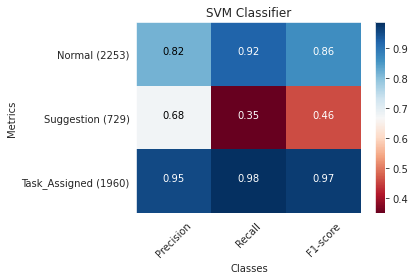

In [0]:
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('SVM Classifier')
plt.show()
plt.close()

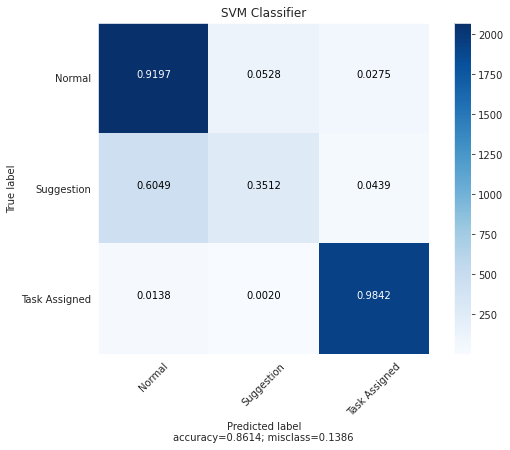

In [0]:
cm = confusion_matrix(y_dev, y_pred)
plot_confusion_matrix(cm, ['Normal','Suggestion','Task Assigned'],title='SVM Classifier')

In [0]:
max_features = 11760
# max_features = 17139
maxlen = 600
embed_size = 300

pos_tags_train = train[0].apply(lambda x : " ".join(item[1] for item in pos_tag(word_tokenize(x)))).values
pos_tags_dev = dev[0].apply(lambda x : " ".join(item[1] for item in pos_tag(word_tokenize(x)))).values

x_train = train[0].values + " " + pos_tags_train
y_train = train[1].values
x_dev = dev[0].values + " " + pos_tags_dev
y_dev = dev[1].values

In the code below we will build a Keras Sequential model with the following layers:

*   The first layer is a TensorFlow Hub layer. This layer uses a pre-trained SavedModel to map a sentence into its embedding vector. The model that we are using (google/tf2-preview/gnews-swivel-20dim/1) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension).
*   This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
*   The last layer is densely connected with a three output node. Using the softmax activation function.

In [0]:
# Hybrid Neural Network classifier

y_train = to_categorical(get_reverse_mapping(train[1]), 3)
y_dev = to_categorical(get_reverse_mapping(dev[1]), 3)

model = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(3, activation = "softmax")])
    
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(x_train, y_train, batch_size = 512, epochs = 25, validation_data = (x_dev, y_dev), verbose = 1)

Epoch 1/20
23/23 [==============================] - 0s 17ms/step - loss: 1.0698 - accuracy: 0.4245 - val_loss: 0.9438 - val_accuracy: 0.5992
Epoch 2/20
23/23 [==============================] - 0s 13ms/step - loss: 0.8516 - accuracy: 0.7029 - val_loss: 0.7723 - val_accuracy: 0.7628
Epoch 3/20
23/23 [==============================] - 0s 13ms/step - loss: 0.6953 - accuracy: 0.7884 - val_loss: 0.6397 - val_accuracy: 0.7948
Epoch 4/20
23/23 [==============================] - 0s 14ms/step - loss: 0.5741 - accuracy: 0.8092 - val_loss: 0.5447 - val_accuracy: 0.8084
Epoch 5/20
23/23 [==============================] - 0s 13ms/step - loss: 0.4902 - accuracy: 0.8191 - val_loss: 0.4836 - val_accuracy: 0.8175
Epoch 6/20
23/23 [==============================] - 0s 13ms/step - loss: 0.4356 - accuracy: 0.8285 - val_loss: 0.4446 - val_accuracy: 0.8240
Epoch 7/20
23/23 [==============================] - 0s 13ms/step - loss: 0.3984 - accuracy: 0.8376 - val_loss: 0.4175 - val_accuracy: 0.8292
Epoch 8/20
23

In [0]:
nn_dev_pred = get_mapping(get_max(model.predict(x_dev, batch_size = 128, verbose = 1)))

train_labels['nn'] = get_mapping(get_max(model.predict(x_train, batch_size = 128, verbose = 1)))
dev_labels['nn'] = nn_dev_pred

y_pred = nn_dev_pred
y_dev = get_mapping(get_max(y_dev))
classification = classification_report(y_dev, y_pred, digits=3).replace('Task Assigned','Task_Assigned')
print(classification)

92/92 [==============================] - 0s 2ms/step
               precision    recall  f1-score   support

       Normal      0.857     0.875     0.866      2253
   Suggestion      0.621     0.538     0.576       729
Task_Assigned      0.962     0.987     0.974      1960

     accuracy                          0.869      4942
    macro avg      0.813     0.800     0.805      4942
 weighted avg      0.864     0.869     0.866      4942



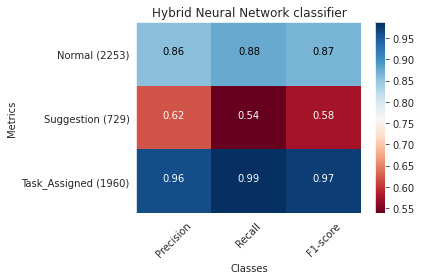

In [0]:
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('Hybrid Neural Network classifier')
plt.show()
plt.close()

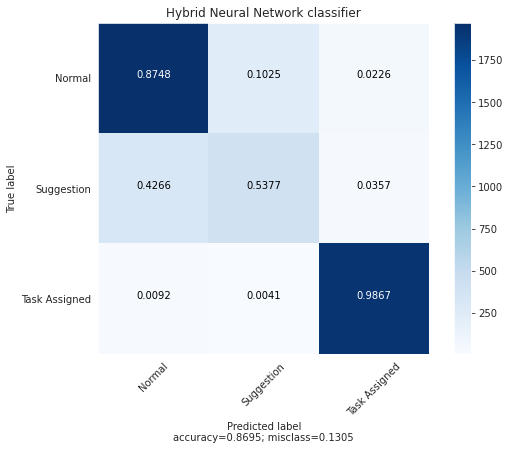

In [0]:
cm = confusion_matrix(y_dev, y_pred)
plot_confusion_matrix(cm, ['Normal','Suggestion','Task Assigned'], title = 'Hybrid Neural Network classifier')

In the code below we will build a Keras Sequential model with the following layers:

*   The first layer is a TensorFlow Hub layer. This layer uses a pre-trained SavedModel to map a sentence into its embedding vector. The model that we are using (google/tf2-preview/nnlm-en-dim128/1) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: (num_examples, embedding_dimension).
*   This fixed-length output vector is piped through a fully-connected (Dense) layer with 20 hidden units.
*   This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
*   The last layer is densely connected with a three output node. Using the softmax activation function.

In [0]:
# Hybrid Neural Network classifier

y_train = to_categorical(get_reverse_mapping(train[1]), 3)
y_dev = to_categorical(get_reverse_mapping(dev[1]), 3)

model = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(3, activation = "softmax")])    

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(x_train, y_train, batch_size = 512, epochs = 25, validation_data = (x_dev, y_dev), verbose = 1)

Epoch 1/25
23/23 [==============================] - 30s 1s/step - loss: 0.9634 - accuracy: 0.5798 - val_loss: 0.7902 - val_accuracy: 0.7847
Epoch 2/25
23/23 [==============================] - 29s 1s/step - loss: 0.6266 - accuracy: 0.8206 - val_loss: 0.4872 - val_accuracy: 0.8357
Epoch 3/25
23/23 [==============================] - 29s 1s/step - loss: 0.3794 - accuracy: 0.8464 - val_loss: 0.3435 - val_accuracy: 0.8632
Epoch 4/25
23/23 [==============================] - 29s 1s/step - loss: 0.2620 - accuracy: 0.9037 - val_loss: 0.2883 - val_accuracy: 0.8834
Epoch 5/25
23/23 [==============================] - 29s 1s/step - loss: 0.1959 - accuracy: 0.9327 - val_loss: 0.2637 - val_accuracy: 0.8928
Epoch 6/25
23/23 [==============================] - 29s 1s/step - loss: 0.1458 - accuracy: 0.9514 - val_loss: 0.2588 - val_accuracy: 0.8968
Epoch 7/25
23/23 [==============================] - 29s 1s/step - loss: 0.1075 - accuracy: 0.9670 - val_loss: 0.2649 - val_accuracy: 0.8950
Epoch 8/25
23/23 [==

In [0]:
nn_dev_pred = get_mapping(get_max(model.predict(x_dev, batch_size = 512, verbose = 1)))

train_labels['nn1'] = get_mapping(get_max(model.predict(x_train, batch_size = 512, verbose = 1)))
dev_labels['nn1'] = nn_dev_pred

y_pred = nn_dev_pred
y_dev = get_mapping(get_max(y_dev))
classification = classification_report(y_dev, y_pred, digits=3).replace('Task Assigned','Task_Assigned')
print(classification)

23/23 [==============================] - 3s 149ms/step
               precision    recall  f1-score   support

       Normal      0.855     0.889     0.872      2253
   Suggestion      0.638     0.565     0.599       729
Task_Assigned      0.988     0.985     0.986      1960

     accuracy                          0.879      4942
    macro avg      0.827     0.813     0.819      4942
 weighted avg      0.876     0.879     0.877      4942



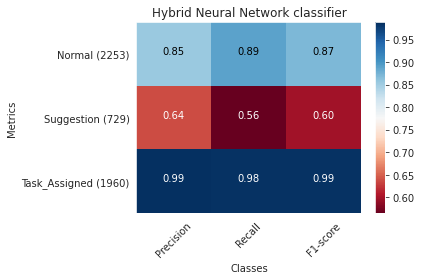

In [0]:
s = classification.split('\n\n')
classification = s[0] + '\n\n' + s[1]
plot_classification_report(classification)
plt.title('Hybrid Neural Network classifier')
plt.show()
plt.close()

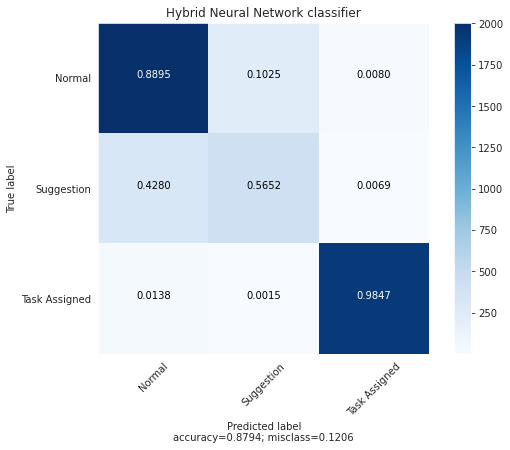

In [0]:
cm = confusion_matrix(y_dev, y_pred)
plot_confusion_matrix(cm, ['Normal','Suggestion','Task Assigned'], title = 'Hybrid Neural Network classifier')